In [1]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm
import random
from PIL import Image
import seaborn as sns
import PIL
import json

from process import img_RGB2LAB_preprocess_np

from scipy.ndimage.filters import gaussian_filter
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import shuffle
from makizoo.backbones.resnetv1 import ResNet18
from makizoo.backbones.mobilenetv2 import MobileNetV2_1_4, MobileNetV2_1_0, MobileNetV2_0_75
from makiflow.layers import *
from makiflow.models.classificator import Classificator, CETrainer
from makiflow.generators.classification import cycle_generator
from makiflow import set_main_gpu

set_main_gpu(2)

In [2]:
use_saved = True
path_exp = 'exp_classification_kfold/9_exp/'

if use_saved:
    with open(f'{path_exp}/config_data.json', 'r') as fp:
        config_data = json.load(fp)
else:    
    config_data = {'train': [], 'test': []}

SIZE_HW = (336, 336)

path_to_data = 'expand_double_modes'
folders_path = sorted(glob(path_to_data + '/*'), key=lambda x: float(x.split('/')[-1]))
Xtrain = []
Xtest = []

Ytrain = []
Ytest = []
pred2param = {}


test_div = 0.8

if not use_saved:
    print(len(folders_path))
    for i, single_folder in enumerate(folders_path):
        # Single folder - 1 class
        pred2param[i] = str(single_folder.split('/')[-1])
        path_images = shuffle(glob(single_folder + '/*'))
        size = len(path_images)
        iterator = tqdm(enumerate(path_images))
        for j, single_img_path in iterator:
            readed_img = cv2.resize(cv2.imread(single_img_path)[..., ::-1], SIZE_HW)
            if int(size * test_div) > j:
                # train
                Xtrain.append(readed_img)
                Ytrain.append(i)
                config_data['train'] += [single_img_path]
            else:
                # test
                Xtest.append(readed_img)
                Ytest.append(i)
                config_data['test'] += [single_img_path]
        iterator.close()

    with open(f'{path_exp}/config_train_test.json', 'w') as fp:
        json.dump(config_data, fp)
else:
    pred2param = dict([(i, num_a.split('/')[-1]) for i, num_a in enumerate(folders_path)])
    param2pred = dict([(num_a.split('/')[-1], i) for i, num_a in enumerate(folders_path)])
    # train
    iterator = tqdm(config_data['train'])
    for single_img_path in iterator:
        readed_img = cv2.resize(cv2.imread(single_img_path)[..., ::-1], SIZE_HW)
        class_f = param2pred[single_img_path.split('/')[1]]
        Xtrain.append(readed_img)
        Ytrain.append(class_f)
    iterator.close()
    # test
    iterator = tqdm(config_data['test'])
    for single_img_path in iterator:
        readed_img = cv2.resize(cv2.imread(single_img_path)[..., ::-1], SIZE_HW)
        class_f = param2pred[single_img_path.split('/')[1]]
        Xtest.append(readed_img)
        Ytest.append(class_f)
    iterator.close()

print('train : ', len(Ytrain))
print('test: ', len(Ytest))

100%|██████████| 3780/3780 [00:06<00:00, 624.55it/s]

train :  34020
test:  3780


In [3]:
coffe_norm = lambda x: (x - 128.0) / 128.0

#Xtrain = coffe_norm(np.array(Xtrain)).astype(np.float32)
#Xtest = coffe_norm(np.array(Xtest)).astype(np.float32)

Ytrain = np.array(Ytrain).astype(np.int32)
Ytest = np.array(Ytest).astype(np.int32)

In [4]:
%matplotlib inline

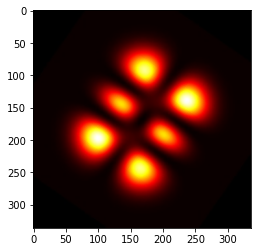

In [5]:
plt.imshow(Xtrain[2])

In [6]:
BATCH_SIZE = 64

In [7]:
inp, x = ResNet18([BATCH_SIZE, SIZE_HW[0], SIZE_HW[1], 3])

x = GlobalAvgPoolLayer('flat')(x)
# Head1
x = DropoutLayer(name='drop_final', p_keep=0.75)(x)
x = DenseLayer(in_d=x.get_shape()[-1], out_d=21, use_bias=False, activation=None, name='classification_head1')(x)

In [8]:
model = Classificator(inp, x, name='MakiResNet')
sess = tf.Session()
model.set_session(sess)

In [9]:
model.load_weights('exp_classification_kfold/9_exp/acc_0.73_ep_3_exp/weights.ckpt')


INFO:tensorflow:Restoring parameters from exp_classification_kfold/9_exp/acc_0.73_ep_3_exp/weights.ckpt
Weights are loaded.


In [10]:
trainer = CETrainer(model, [inp])
trainer.compile()



Loss is built.


In [ ]:
len(Ytrain)

In [ ]:
global_step = tf.Variable(0, dtype=tf.int32)
lr = tf.train.exponential_decay(5e-3, global_step, decay_steps=(len(Ytrain) // BATCH_SIZE) * 2, decay_rate=0.92)
opt = tf.train.AdamOptimizer(lr)
sess.run(tf.variables_initializer([global_step]))

In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(A):
    """
    Computes a softmax function. 
    Input: A (N, k) ndarray.
    Returns: (N, k) ndarray.
    """
    e = np.exp(A)
    return e / np.sum(e, axis=-1, keepdims=True)

def predict(data_pr):
    output_mf = x
    ans = [
        output_mf.eval(feed_dict={inp: data_pr[i*BATCH_SIZE:(i+1)*BATCH_SIZE]}, sess=sess) 
        for i in range(len(data_pr)//BATCH_SIZE)
    ]
    ans = np.concatenate(ans, axis=0).reshape(-1, 21)
    
    return ans.astype(np.float32, copy=False)
    
def eval_model(x_data, y_data, calc_mean=True):
    global model
    accur_list = []
    predictions_list = []
    
    for i in range(len(x_data)//BATCH_SIZE):
        batched_data_x = preprocess_img(x_data[i*BATCH_SIZE:(i+1)*BATCH_SIZE])
        batched_data_y = y_data[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        argmax_np = np.argmax(softmax(predict(batched_data_x)), axis=-1)
        predictions_list.append(argmax_np)
        accur_list.append(argmax_np == batched_data_y)
        
    accur_np = np.asarray(accur_list).reshape(-1)
    pred_np = np.asarray(predictions_list).reshape(-1)
    if not calc_mean:
        return accur_np, pred_np
    
    return np.mean(accur_list), pred_np


def preprocess_img(data):
    data = np.asarray(data).astype(np.float32, copy=False)
    return coffe_norm(data).astype(np.float32, copy=False)
    #return img_RGB2LAB_preprocess_np(data).astype(np.float32, copy=False)



def generator_wrapper(gen_data, *args):
    while True:
        X_data, Y_data = next(gen_data)
        X_data = X_data[0]
        Y_data = Y_data[0]
        """
        # Aug rotation and flip of the image
        # In my case - images already rotated
        
        rotate_angle = np.random.uniform(-90, 90, size=(len(X_data))).astype(np.float32)
        #X_data = [ndimage.rotate(X_data[i], rotate_angle[i], reshape=False) for i in range(len(X_data))]
        X_data = [
            np.array(
                Image.fromarray(X_data[i]).rotate(rotate_angle[i], resample=Image.BICUBIC).getdata()
            ).reshape(SIZE_HW[0], SIZE_HW[1], 3)
            for i in range(len(X_data))
        ]
        
        ra = random.random()
        type_rotate = None
        
        if ra > 0.3 and ra < 0.5:
            type_rotate = cv2.ROTATE_180
        elif ra > 0.5 and ra < 0.7:
            type_rotate = cv2.ROTATE_90_CLOCKWISE
        elif ra > 0.7:
            type_rotate = cv2.ROTATE_90_COUNTERCLOCKWISE
        
        if type_rotate is not None:
            X_data = [cv2.rotate(X_data[i], type_rotate) for i in range(len(X_data))]
        """
        
        # sigma more than 1.0 - gives very bad looking image, i.e. sigma must be lower than 1.0
        #if random.random() > 0.6:
        #    X_data = [gaussian_filter(X_data[i], sigma=0.5) for i in range(len(X_data))]
        
        if random.random() > 22.5:
            X_data = np.asarray(X_data).astype(np.float32, copy=False)
            X_data += np.random.normal(scale=0.25, size=X_data.shape).astype(np.float32, copy=False)
        
        X_data = preprocess_img(X_data)
        
        yield (X_data,), (Y_data, )


gen = generator_wrapper(cycle_generator(Xtrain, Ytrain.reshape(-1), BATCH_SIZE))

In [ ]:
xxx = next(gen)[0]

In [ ]:
plt.imshow(xxx[0][8])

In [ ]:
trainer.set_common_l2_weight_decay(5e-5)

In [ ]:
accur_list = []

for z in range(20):
    print('ep: ', z)
    info1 = trainer.fit_generator(
        gen, optimizer=opt, epochs=1, 
        iter=len(Xtrain)//(2*BATCH_SIZE), print_period=150, global_step=global_step
    )
    acc_float, _ = eval_model(Xtest, Ytest)
    print('acc test: ', acc_float)
    accur_list.append(acc_float)
    if acc_float > 0.95:
        print('Stop!')
        break
    

In [ ]:
plt.plot(accur_list)

In [13]:
acc_test, predictions = eval_model(Xtest, Ytest, calc_mean=False)
print(np.mean(acc_test))

0.729343220338983


## Look at wrong predictions

In [ ]:
# Error of nn
img_wrong = np.asarray(Xtest[:len(acc_test)])[acc_test == False]
y_wrong = Ytest[:len(acc_test)][acc_test == False]
p_wrong = predictions[:len(acc_test)][acc_test == False]

In [ ]:
temp = acc_test == False
counter_h = 0
for i in range(len(temp)):
    if temp[i]:
        print(i, 'c: ', counter_h, ' file: ', config_data['test'][i])
        counter_h += 1

In [ ]:
indx = 322
print('true: ', pred2param[y_wrong[indx]], ' pred: ', pred2param[p_wrong[indx]])
plt.imshow(img_wrong[indx])

In [ ]:
for i in range(len(Ytrain)):
    if 'z_60_angle_45.jpg' == config_data['train'][i] and pred2param[Ytrain[i]] == '0.95':
        print(i)

In [ ]:
for i in range(len(Ytest)):
    if 'z_60_angle_45.jpg' == config_data['test'][i] and pred2param[Ytest[i]] == '0.9':
        print(i)

In [ ]:
for i in range(len(Ytest)):
    if 'z_380_angle_-60.jpg' == config_data['test'][i] and pred2param[Ytest[i]] == '0.85':
        print(i)

In [ ]:
plt.imshow(Xtest[6726])

In [ ]:
plt.imshow(Xtrain[27604])

In [ ]:
sns.heatmap(np.abs(np.sum(Xtrain[27604].astype(np.float32) - Xtest[6726].astype(np.float32), axis=-1)))

In [ ]:
plt.plot(info1[trainer.TRAINING_LOSS])

In [ ]:
assert 1 == 3

## Save arch/weights

In [ ]:
#model.save_weights(f'{path_exp}/weights.ckpt')
#model.save_architecture(f'{path_exp}/model.json')

model.load_weights(f'{path_exp}/weights.ckpt')

In [ ]:
assert 1 == 3

## Deep analyze

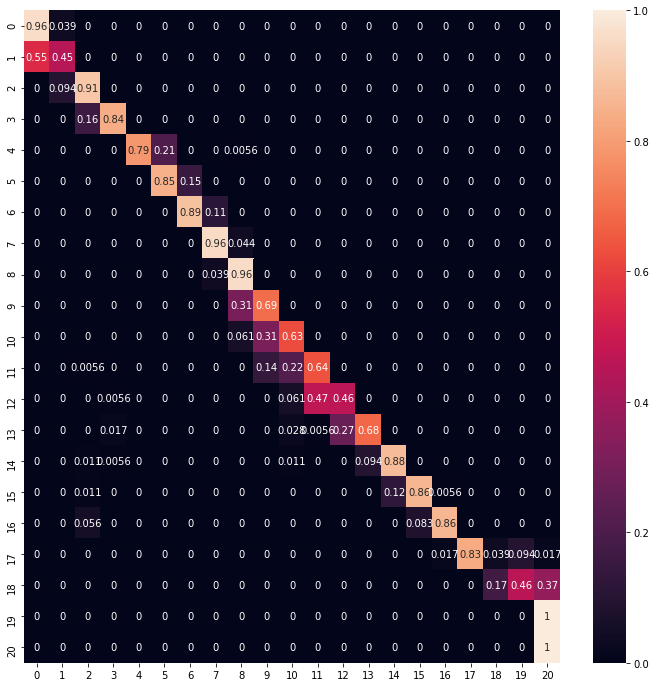

In [19]:
c_mat = confusion_matrix(
    Ytest[:len(predictions)].reshape(-1), predictions.reshape(-1), 
    labels=range(21), normalize='true'
).astype(np.float32) 
#c_mat = np.round(c_mat / (len(Xtest) // 21), 2)
fig = plt.figure(figsize=(12, 12))
sns.heatmap(c_mat, annot=True)
fig.savefig('result_conf.png')

In [ ]:
assert 1 == 3

In [ ]:
# Error of nn
y_z = Ytest[:len(predictions)].copy()
p_z = predictions[:len(predictions)].copy()

# dict - dict of every angle, each elem is array of size 2, 0-th - wrong pred, 1-th - all image
angle_pred_count_d = dict([(str(i), None) for i in range(-90, 90, 5)])

for i in range(len(predictions)):
    angle_info = config_data['test'][i].split('/')[-1].split('.')[0].split('_')[-1]
    
    # Skip class with bigg accuracy
    if y_z[i] not in [20, 19]:
        continue
    
    if angle_pred_count_d[angle_info] is None:
        angle_pred_count_d[angle_info] = [0, 0]
    
    if p_z[i] != y_z[i]:
        angle_pred_count_d[angle_info][0] += 1
    angle_pred_count_d[angle_info][1] += 1


In [ ]:
angle_pred_count_d

In [ ]:
x = [int(single_elem) for single_elem in angle_pred_count_d.keys()]
y = [angle_pred_count_d[k_a][0] / angle_pred_count_d[k_a][-1] for k_a in angle_pred_count_d]

fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_facecolor('seashell')
ax.set_xlabel('Угол')
ax.set_ylabel('% отношение ошибки ко всем кадрам')
fig.set_facecolor('floralwhite')
fig.set_figwidth(16)    #  ширина Figure
fig.set_figheight(8)    #  высота Figure
plt.show()

In [ ]:
# Error of nn on certain classes
first_class = 19
second_class = 20
class_find = range(-90, 90, 5)#[first_class, second_class] range(-90, 90, 5)
class_count = dict([(elem, 0) for elem in class_find])

y_z = Ytest[:len(predictions)].copy()
p_z = predictions[:len(predictions)].copy()

# dict - dict of every angle, each elem is array of size 2, 0-th - wrong pred, 1-th - all image
angle_count = dict([(str(i), 0) for i in range(-90, 90, 5)])
pred_data_angle = []
true_data_angle = []

eror_counter = 0
success_counter = 0

test_y = []
test_p = []

for i in range(len(predictions)):
    angle_info = config_data['test'][i].split('/')[-1].split('.')[0].split('_')[-1]
    class_name_z = config_data['test'][i].split('/')[1]
    
    # Skip class with bigg accuracy
    if y_z[i] not in class_find:
        continue
    
    if p_z[i] != y_z[i]:
        pred_data_angle.append(float(angle_info))
        true_data_angle.append(float(angle_info))
        eror_counter += 1
    else:
        pred_data_angle.append(float(100000000000.0)) # wrong pred
        true_data_angle.append(float(angle_info))
        success_counter += 1
    angle_count[angle_info] += 1

    test_y.append(y_z[i])
    test_p.append(p_z[i])

In [ ]:
angle_count

In [ ]:
len(predictions)

In [ ]:
c_mat = confusion_matrix(true_data_angle, pred_data_angle, labels=range(-90, 90, 5)).astype(np.float32)

In [ ]:
c_mat

In [ ]:
print('s: ', sum([c_mat[i, i] for i in range(len(list(range(-90, 90, 5))))]))

In [ ]:
c_mat = confusion_matrix(true_data_angle, pred_data_angle, labels=range(-90, 90, 5)).astype(np.float32) 
for i, z in enumerate(range(-90, 90, 5)):
    c_mat[i, i] /= float(angle_count[str(z)])
fig, ax = plt.subplots(figsize=(26, 26), facecolor='white')
sns.heatmap(
    c_mat, annot=True, 
    xticklabels=list(range(-90, 90, 5)), yticklabels=list(range(-90, 90, 5))
)
print('s: ', sum([c_mat[i, i] for i in range(len(list(range(-90, 90, 5))))]))
fig.savefig('result_conf_angle.png', facecolor=fig.get_facecolor(), edgecolor='none')

#### Check accuracy on train data

In [ ]:
predictions = model.predict(coffe_norm(np.array(Xtrain)))
predictions = np.argmax(predictions, axis=-1)
print(np.mean(predictions == Ytrain.reshape(-1)))

In [ ]:
assert 1 == 3

In [16]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm
import random
from PIL import Image
import seaborn as sns
import PIL
import json

from process import img_RGB2LAB_preprocess_np

from scipy.ndimage.filters import gaussian_filter
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import shuffle
from makizoo.backbones.resnetv1 import ResNet18
from makizoo.backbones.mobilenetv2 import MobileNetV2_1_4, MobileNetV2_1_0, MobileNetV2_0_75
from makiflow.layers import *
from makiflow.models.classificator import Classificator, CETrainer
from makiflow.generators.classification import cycle_generator


WRONG_PREDICTIONS = 100000.0


def save_conf_matrix(Ytest, predictions, path_save, save_np=True):
    c_mat = confusion_matrix(
        Ytest[:len(predictions)].reshape(-1), predictions.reshape(-1), 
        labels=range(21), normalize='true'
    ).astype(np.float32) 
    c_mat = np.round(c_mat, 2).astype(np.float32, copy=False)
    
    fig = plt.figure(figsize=(12, 12))
    sns.heatmap(c_mat, annot=True)
    fig.savefig(path_save + '.png')
    plt.close('all')
    if save_np:
        np.save(path_save + '.npy', c_mat)


def _rotation_range():
    return range(-90, 90, 5)


def error_angle(path_save, config_data, Ytest, predictions, class_find=list(range(21)), save_np=True):
    y_z = Ytest[:len(predictions)].copy()
    p_z = predictions.copy()

    # dict - dict that store error of every angle, 
    # Each elem is array of size 2, 
    # 0-th - number of wrong preds, 1-th - number of all images
    angle_count = dict([(str(i), 0) for i in _rotation_range()])
    pred_data_angle, true_data_angle = [], []
    test_y, test_p = [], []

    for i in range(len(predictions)):
        # Skip class certain classes, (in order to collect data for certain classes)
        if y_z[i] not in class_find:
            continue
        # 90, 95, -55 and etc...
        angle_info = config_data['test'][i].split('/')[-1].split('.')[0].split('_')[-1]
        # 0.0, 0.2 and etc...
        #class_name_z = config_data['test'][i].split('/')[1]
        
        if p_z[i] != y_z[i]:
            pred_data_angle.append(float(angle_info))
            true_data_angle.append(float(angle_info))
        else:
            pred_data_angle.append(WRONG_PREDICTIONS)
            true_data_angle.append(float(angle_info))
        angle_count[angle_info] += 1
        test_y.append(y_z[i])
        test_p.append(p_z[i])

    c_mat = confusion_matrix(true_data_angle, pred_data_angle, labels=_rotation_range()).astype(np.float32) 
    for i, z in enumerate(_rotation_range()):
        c_mat[i, i] /= float(angle_count[str(z)])
    fig, ax = plt.subplots(figsize=(26, 26), facecolor='white')
    sns.heatmap(
        c_mat, annot=True, 
        xticklabels=list(_rotation_range()), yticklabels=list(_rotation_range())
    )
    fig.savefig(path_save + '.png', facecolor=fig.get_facecolor(), edgecolor='none')
    plt.close('all')
    if save_np:
        np.save(path_save + '.npy', c_mat)



In [22]:
error_angle('test', config_data, Ytest, predictions, [20], False)

<ipython-input-16-4f45108049fe>:80: RuntimeWarning: invalid value encountered in true_divide
  c_mat[i, i] /= float(angle_count[str(z)])


### TSNE and PCA analyze

In [ ]:
output_mf = model.get_node('flat')

In [ ]:
ans = [output_mf.eval(feed_dict={inp: Xtest[i*BATCH_SIZE:(i+1)*BATCH_SIZE]}, sess=sess) for i in range(len(Xtest)//BATCH_SIZE)]

In [ ]:
ans = np.concatenate(ans, axis=0)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
single_class_num = len(Xtest) // 21

certain_classes = [19, 20]
new_ans = []
y_new_ans = []
img_orig = []

for single_class in certain_classes:
    for indx_z in range(single_class_num*single_class, min((single_class+1)*single_class_num, len(ans))):
        new_ans.append(ans[indx_z])
        y_new_ans.append(Ytest[indx_z])
        img_orig.append(Xtest[indx_z])

new_ans = np.array(new_ans)
y_new_ans = np.array(y_new_ans)

In [ ]:
%matplotlib inline

In [ ]:
pca = PCA()
reduced = pca.fit_transform(new_ans)
plt.scatter(reduced[:,0],reduced[:,1] ,s=100,c=y_new_ans[:ans.shape[0]],alpha=0.5)
plt.savefig('pca_0_20.jpg')

In [ ]:
tsne = TSNE()
Z = tsne.fit_transform(new_ans)
plt.scatter(Z[:,0],Z[:,1] ,s=100,c=Ytest[:y_new_ans.shape[0]],alpha=0.5)
plt.savefig('tsne_0_20.jpg')

In [ ]:
%matplotlib notebook

In [ ]:
# 0 AND 20
tsne = TSNE(n_components=3)
Z = tsne.fit_transform(new_ans)
figure = plt.figure(figsize=(9,9))
axes = figure.add_subplot(111,projection = "3d")
dots = axes.scatter(xs = Z[:,0],ys = Z[:,1],zs = Z[:,2],
                    c=Ytest[:new_ans.shape[0]], cmap = plt.cm.get_cmap("nipy_spectral_r",10))

In [ ]:
# 19 AND 20
tsne = TSNE(n_components=3)
Z = tsne.fit_transform(new_ans)
figure = plt.figure(figsize=(9,9))
axes = figure.add_subplot(111,projection = "3d")
dots = axes.scatter(xs = Z[:,0],ys = Z[:,1],zs = Z[:,2],
                    c=Ytest[:new_ans.shape[0]], cmap = plt.cm.get_cmap("nipy_spectral_r",10))

### Look for clusters

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
k_means = KMeans(n_clusters=3)
k_means.fit(Z)
k_means_predicted = k_means.predict(Z)
centers = k_means.cluster_centers_

figure = plt.figure(figsize=(9,9))
axes = figure.add_subplot(111,projection = "3d")
dots = axes.scatter(xs = centers[:,0],ys = centers[:,1],zs = centers[:,2],
                    c=[1,2,3], cmap = plt.cm.get_cmap("nipy_spectral_r",10))

In [ ]:
centers

In [ ]:
main_center = centers[2]
lower = np.sum( (main_center - Z[0]) ** 2)
lower_indx = 0

for i in range(len(Z)):
    if np.sum( (main_center - Z[i]) ** 2) < lower:
        lower_indx = i
        lower = np.sum( (main_center - Z[i]) ** 2)

In [ ]:
%matplotlib inline

In [ ]:
plt.imshow(img_orig[lower_indx])

In [ ]:
lower

In [ ]:
assert 1 == 3

## Analyze data through fft

In [ ]:
single_img = Xtest[9686] #13780 2927

In [ ]:
plt.imshow(single_img)

In [ ]:
single_img = Xtest[2927] #13780 2927
plt.imshow(single_img)

In [ ]:
single_img_t = single_img.transpose(-1, 0, 1)[0]

In [ ]:
single_img_t = np.zer (single_img_t, )

In [ ]:
shift_im = np.fft.fftshift(single_img_t)

In [ ]:
fft_im = np.fft.fft2(shift_im)

In [ ]:
np.abs(fft_im).shape

In [ ]:
sns.heatmap(np.abs(fft_im))

In [ ]:
shift_fft_im = np.fft.fftshift(fft_im)

In [ ]:
sns.heatmap(np.abs(shift_fft_im))

In [ ]:
sns.heatmap(np.angle(shift_fft_im))

In [ ]:
def fast_fourier_transform_2d(f, N, M, a):
    h = 1e-5
    padding = (M - N) // 2
    
    input_f = np.pad(f, padding)          # Шаг 2
    input_f = np.fft.fftshift(input_f)    # Шаг 3
    res = np.fft.fft2(input_f) * (h ** 2) # Шаг 4 
    
    res = np.fft.fftshift(res)
    fft_result = res[padding:-padding, padding:-padding]
    
    b = (N ** 2) / (4 * a * M)
    xv, yv = np.linspace(-b, b, N), np.linspace(-b, b, N)
    new_xs, new_ys = np.meshgrid(xv, yv)
    return fft_result, new_xs, new_ys, b

In [ ]:
fft_result, new_xs, new_ys, b = fast_fourier_transform_2d(single_img_t, 336, 512, 3)

In [ ]:
sns.heatmap(np.angle(fft_result))

In [ ]:
sns.heatmap(np.angle(fft_result))

In [ ]:
sns.heatmap(np.abs(fft_result))#[100:250, 120:200])

In [ ]:
sns.heatmap(np.abs(fft_result))#[100:250, 120:200])

In [ ]:
a = cv2.cvtColor(cv2.imread('expand_double_modes/0.95/z_600_angle_0.jpg'), cv2.COLOR_BGR2RGB) #Xtest[9686]
a = a.transpose(-1, 0, 1)[0]
b = cv2.cvtColor(cv2.imread('expand_double_modes/1.0/z_600_angle_0.jpg'), cv2.COLOR_BGR2RGB) #Xtest[2927]
b = b.transpose(-1, 0, 1)[0]

In [ ]:
%matplotlib inline

In [ ]:
fft_resultbbbb, new_xs, new_ys, _ = fast_fourier_transform_2d(b, 336, 4048, 3)
sns.heatmap(np.angle(fft_resultbbbb))

In [ ]:
fft_resultaaaaa, new_xs, new_ys, _ = fast_fourier_transform_2d(a, 336, 4048, 3)
sns.heatmap(np.angle(fft_resultaaaaa))

In [ ]:
sns.heatmap(np.abs(fft_resultaaaaa)) #[100:250, 120:200])

In [ ]:
sns.heatmap(np.abs(fft_resultbbbb)) #[100:250, 120:200])

In [ ]:
plt.imshow(a)

In [ ]:
plt.imshow(b)

In [ ]:
plt.imshow(np.abs(a - b))

In [ ]:
assert 1 == 3

In [ ]:
model.save_weights('weights_class/weights.ckpt')

In [ ]:
list(x.get_previous_tensors().keys())

In [ ]:
sns.distplot(img_RGB2LAB_preprocess_np(np.asarray(Xtest[:2])))